# Talleres intermedios OHW 2025 Cotsikayala Pacheco Ramírez
# 1. Ejercicio de análisis temporal de Temperatura del mar para México.

# El término TSM se refiere a la capa o piel del océano y representa la temperatura de la capa subsuperficial a una profundidad entre 10–20 µm. La TSM es un producto de reanálisis proporcionado por COPERNICUS de la Union Europea.

### Parametros:

In [17]:
zona = 'México'
nombre_salida = "TEMPLATE_espacial"
print('Zona: ', zona)

Zona:  México


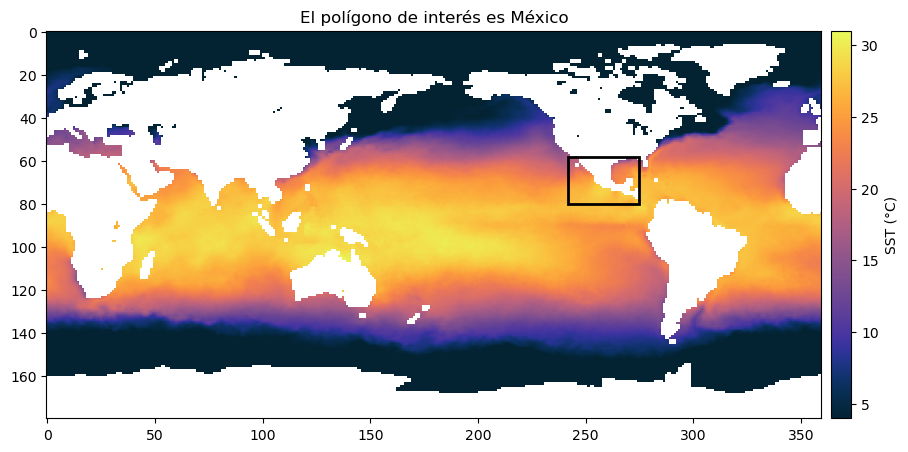

In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cmo
from matplotlib.patches import Polygon

# Cargar datos
path = "/home/jovyan/shared/datos_para_tutoriales/Talleres_intermedios/6-Octubre-2025/datos_temporales_python/ERA5_Coarse.nc"
ds = xr.open_dataset(path)
sst = ds["sst"] - 273.15  # convertir a °C

# Polígono de interés en coordenadas lon/lat
lon_min, lon_max = 275, 242
lat_min, lat_max = 10, 32

# Crear figura
cmap = cmo.cm.thermal
fig, ax = plt.subplots(figsize=(10,6))

# Graficar SST tiempo 0
image = ax.imshow(sst.isel(time=0), cmap=cmap, vmin=4, vmax=31)

# Barra de color al lado
cax = fig.add_axes([ax.get_position().x1 + 0.01,
                    ax.get_position().y0, 0.02,
                    ax.get_position().height])
cbar = plt.colorbar(image, cax=cax)
cbar.set_label('SST (°C)')

# Convertir coordenadas del polígono a índices de matriz
lat = ds.latitude.values
lon = ds.longitude.values

# Encontrar los índices más cercanos a los límites del polígono
i_min = np.argmin(np.abs(lat - lat_min))
i_max = np.argmin(np.abs(lat - lat_max))
j_min = np.argmin(np.abs(lon - lon_min))
j_max = np.argmin(np.abs(lon - lon_max))

# Crear polígono en coordenadas de imagen (x=j, y=i)
poly_coords = [(j_min, i_min), (j_min, i_max),
               (j_max, i_max), (j_max, i_min)]
patch = Polygon(poly_coords, closed=True, edgecolor='black',
                facecolor='none', linewidth=2)
ax.add_patch(patch)

ax.set_title("El polígono de interés es México")
plt.show()

# 1.1 Análisis de serie de tiempo de Temperatura para México

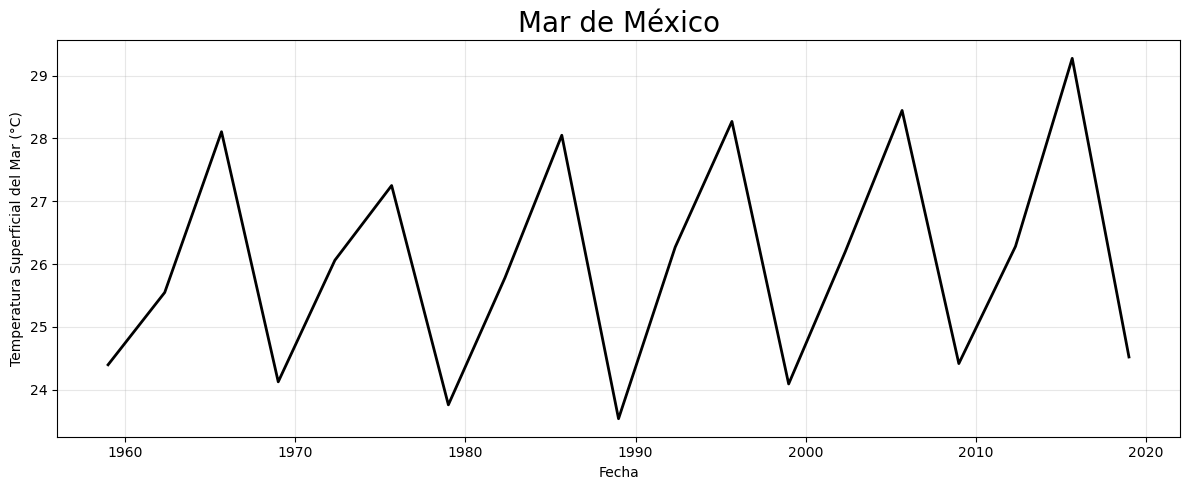

In [19]:
# Seleccionar el polígono México 
mask_lon = (ds.longitude >= lon_max) & (ds.longitude <= lon_min)
mask_lat = (ds.latitude >= lat_min) & (ds.latitude <= lat_max)
mask = mask_lon & mask_lat

# Aplicar el poligono a los datos para extraer los datos y convertir a DataFrame
sst_poly = sst.where(mask, drop=True)
df_poly = sst_poly.to_dataframe().reset_index()

# Calcular el promedio
df_mean = df_poly.groupby('time')['sst'].mean().reset_index()

# Graficar la serie de tiempo de temperatura 
plt.figure(figsize=(12,5))
plt.plot(df_mean['time'], df_mean['sst'], color='k', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Superficial del Mar (°C)')
plt.title('Mar de México', fontsize=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Ejercicio de análisis espacial de temperatura superficial del mar para México

Estadísticas de Temperatura Superficial del Mar:
Temperatura mínima: 17.75 °C
Temperatura máxima: 31.29 °C
Temperatura promedio: 28.24 °C


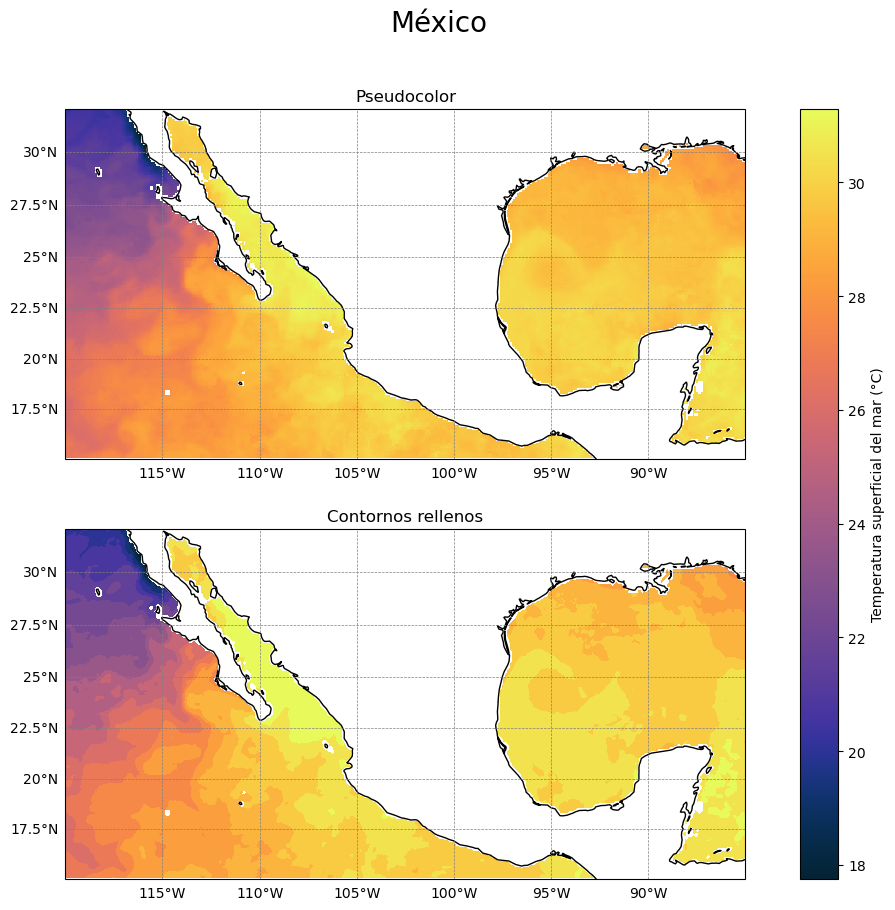

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
# 1. Cargar el archivo NetCDF
path = '/home/jovyan/shared/datos_para_tutoriales/Talleres_intermedios/7-Octubre-2025/datos_espaciales_python/20251004120000-REMSS-L4_GHRSST-SSTfnd-MW_IR_OI-GLOB-v02.0-fv05.1.nc'
ds = xr.open_dataset(path)
# El área de interés es "México" que esta entre las siguientes coordenadas
lon_min, lon_max = -120, -85
lat_min, lat_max = 15, 32
# 3. Seleccionamos el primer tiempo 0 = día 1, se puede mover si nuestro archivo tiene diferentes fechas
sst_data = ds.analysed_sst.isel(time=0) - 273.15  ## Pasamos a grados celsius
# 2. Seleccionamos el área de interes "México"
sst_region = sst_data.sel(
    lon=slice(lon_min, lon_max),
    lat=slice(lat_min, lat_max)
)
# 3. Calcular estadísticas para definir la escala de colores en la barra de temperatura
sst_min = float(sst_region.min())
sst_max = float(sst_region.max())
sst_mean = float(sst_region.mean())

print("Estadísticas de Temperatura Superficial del Mar:")
print(f"Temperatura mínima: {sst_min:.2f} °C")
print(f"Temperatura máxima: {sst_max:.2f} °C")
print(f"Temperatura promedio: {sst_mean:.2f} °C")
# 4. Graficar el mapa con la proyección Miller
fig, axes = plt.subplots(2, 1, figsize=(10, 10),
                         subplot_kw={'projection': ccrs.Miller()})
vmin = sst_min
vmax = sst_max
cmap = cmocean.cm.thermal
# Panel 1: Pseudocolor (pcolormesh)
p1 = sst_region.plot.pcolormesh(ax=axes[0],
                                transform=ccrs.PlateCarree(),
                                cmap=cmap,
                                vmin=vmin, vmax=vmax,
                                add_colorbar=False)  # Desactivamos la barra individual

axes[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
axes[0].coastlines(color='k')
axes[0].add_feature(cfeature.LAND, color='white')
axes[0].set_title("Pseudocolor")
gl1 = axes[0].gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl1.top_labels = False
gl1.right_labels = False

# Panel 2: Contornos rellenos (contourf)
levels = np.linspace(vmin, vmax, 20)
p2 = sst_region.plot.contourf(ax=axes[1],
                              transform=ccrs.PlateCarree(),
                              cmap=cmap,
                              levels=levels,
                              vmin=vmin, vmax=vmax,
                              add_colorbar=False)

axes[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
axes[1].coastlines(color='k')
axes[1].add_feature(cfeature.LAND, color='white')
axes[1].set_title("Contornos rellenos")
gl2 = axes[1].gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl2.top_labels = False
gl2.right_labels = False

plt.suptitle(f"México", fontsize=20)
cbar = fig.colorbar(p1, ax=axes, orientation='vertical', fraction=0.05, pad=0.07)
cbar.set_label("Temperatura superficial del mar (°C)")
plt.show()

In [22]:
import subprocess
# Nombre del notebook sin extensión
nombre_entrada = "InformeCotsikayalaHTML"
nombre_salida = "InformeCotsikayalaOHW2025"
# Construimos el comando nbconvert
command = f'jupyter nbconvert --to html --no-input {nombre_entrada}.ipynb --output {nombre_salida}.html'

# Ejecutamos el comando
subprocess.run(command, shell=True, check=True)

[NbConvertApp] Converting notebook InformeCotsikayalaHTML.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 848472 bytes to InformeCotsikayalaOHW2025.html


CompletedProcess(args='jupyter nbconvert --to html --no-input InformeCotsikayalaHTML.ipynb --output InformeCotsikayalaOHW2025.html', returncode=0)